Names:
1) Klaus Kades (Uni-id: fw448 Matrikelnr.: 3408463)

2) Lucas-Raphael Müller (Uni-id: al413 Matrikelnr.: 3205638)

3) Melanie Schellenberg (Uni-id: qh400 Matrikelnr.: 3146390)

4) Shuhan Xiao (Uni-id: kg410 Matrikelnr.: 3160697)


In [33]:
import pandas as pd 
import networkx as nx 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter
import random

# Assignment 8
## Problem 8-1 European Power Grid 

In [3]:
!wget https://zenodo.org/record/47317/files/gridkit_euorpe.zip --no-clobber


--2022-01-16 19:17:44--  https://zenodo.org/record/47317/files/gridkit_euorpe.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1805506 (1.7M) [application/octet-stream]
Saving to: ‘gridkit_euorpe.zip’

gridkit_euorpe.zip  100%[===================>]   1.72M  2.48MB/s    in 0.7s    

2022-01-16 19:17:46 (2.48 MB/s) - ‘gridkit_euorpe.zip’ saved [1805506/1805506]



In [6]:
!unzip *.zip


Archive:  gridkit_euorpe.zip
  inflating: gridkit_europe-highvoltage-links.csv  
  inflating: gridkit_europe-highvoltage-vertices.csv  
 gridkit_euorpe.zip		        gridkit_europe-highvoltage-vertices.csv
'gridkit_euorpe.zip?download=1'         sample_data
 gridkit_europe-highvoltage-links.csv


In [7]:
!ls

gridkit_euorpe.zip		      gridkit_europe-highvoltage-vertices.csv
gridkit_europe-highvoltage-links.csv  sample_data


In [11]:
data = pd.read_csv('./gridkit_europe-highvoltage-links.csv', sep=',')

display(data)

,l_id,v_id_1,v_id_2,voltage,cables,wires,frequency,name,operator,ref,length_m,r_ohmkm,x_ohmkm,c_nfkm,i_th_max_a,from_relation,wkt_srid_4326
0,22139,43193,23620,220000;132000,9,2,50,NaN,ATEL; BKW,NaN,489.727561,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(7.61602141237887 47.23259...
1,65908,42022,13686,750000,3;1;1;1;3,4;4;4;4,NaN,750 kV,NaN,NaN,394971.083012,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(26.6449735029238 50.29628...
2,67370,6913,48526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10602.245828,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(18.1844471738857 40.01608...
3,3868,35422,28973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2385.934530,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(10.2724738664462 49.88060...
4,4982,7864,63104,225000,3,1,50,NaN,RTE,NaN,1449.986592,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(3.80033661099728 45.04510...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18799,33852,65400,65401,330000,3,NaN,NaN,NaN,NaN,Л-238,181.804718,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(34.891839086949 48.400953...
18800,12859,61910,20324,220000,3;6,NaN,NaN,Somplago-Pordenone,NaN,22.265,873.335875,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(13.0725880043994 46.33610...
18801,17974,29715,22966,220000,3,NaN,NaN,NaN,NaN,NaN,40101.622386,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(22.9977678819448 63.71031...
18802,69707,36830,2741,400000,6;3;3,2,NaN,Realtor Tavel,RTE,NaN,1568.735938,NaN,NaN,NaN,NaN,NaN,SRID=4326;LINESTRING(5.34304391214955 43.44674...


create network

In [12]:
G = nx.from_pandas_edgelist(data, source='v_id_1',target='v_id_2')
print(nx.info(G))
# convert to undirected graph
G = G.to_undirected()

Graph with 13844 nodes and 17277 edges


In [13]:
G = nx.Graph(G) # multigraph to graph
print(nx.info(G))

Graph with 13844 nodes and 17277 edges


1. Molloy-Reed criterion: Calculate $\kappa$

In [17]:
# average degree <k>
degrees = [val for (node, val) in G.degree()]
avg_k = sum(degrees)/len(degrees)
print(f"<k> = {avg_k}")

<k> = 2.4959549263218723


In [23]:
# second moment of degree <k^2>
avg_k2 = sum([k**2 for k in degrees])/len(degrees)
print(f"<k^2> = {avg_k2}")

<k^2> = 7.888182606183184


In [22]:
# Molloy-Reed criterion
kappa = avg_k2/avg_k
print(f"Molloy-Reed: kappa = {kappa}")

Molloy-Reed: kappa = 3.1603866411992825


$\kappa > 2$, i.e. the Molloy-Reed criterion is satisfied and a giant component is expected in the network.

2. Absolute and relative size of the largest component:


In [26]:
largest_cc = max(nx.connected_components(G), key=len)
print(f"absolute size of largest component {len(largest_cc)}")
print(f"relative size of largest component {len(largest_cc)/G.number_of_nodes()}")

absolute size of largest component 13478
relative size of largest component 0.9735625541750939


Yes, the largest component is almost of the same size as the network and can therefore be regarded as the giant component.

3. Compute $f_c$ and $f_c^{ER}$ for the network’s degree distribution. 

In [28]:
fc = 1-1/(kappa-1)
fc_ER = 1-1/avg_k
print(f"fc = {fc} < fc_ER = {fc_ER}")

fc = 0.5371198928332217 < fc_ER = 0.5993517393065926


The critical threshold of the network is slightly smaller than what would be expected by an Erdős–Rényi model with the same $\left<k\right>$, the network is therefore slightly less robust against random failure.

4. 
(i) maximum component size and the (ii) average component size as a function of f ∈ [0,1].



In [57]:
def get_component_sizes(G, n_samples=10, f_samples=21):
  fractions = np.linspace(0,1,f_samples)
  G = G.copy()
  N = G.number_of_nodes()
  Gc_0 = len(max(nx.connected_components(G), key=len))
  Gc_max = np.zeros((len(fractions),n_samples))
  Gc_avg = np.zeros((len(fractions),n_samples))
  for i in range(n_samples):
    for j, f in enumerate(fractions):
      G_ = G.copy()
      nodes = [n for n in G_.nodes]
      # remove f*N nodes
      if f > 0.0:
        rnd_nodes = random.sample(nodes,round(f*N))
        for n in rnd_nodes:
          G_.remove_node(n)
      cc = [len(c) for c in sorted(nx.connected_components(G_), key=len, reverse=True)]
      largest_cc = max(cc) if len(cc)>0 else 0
      Gc_max[j,i] = largest_cc
      Gc_avg[j,i] = sum(cc)/len(cc) if len(cc)>0 else 0
  Gc_max = np.average(Gc_max,axis=1)
  Gc_avg = np.average(Gc_avg,axis=1)
  return Gc_max, Gc_avg, fractions

In [58]:
Gc_max, Gc_avg, fractions = get_component_sizes(G, n_samples=10)


Text(0.5, 1.0, 'Average Component Size')

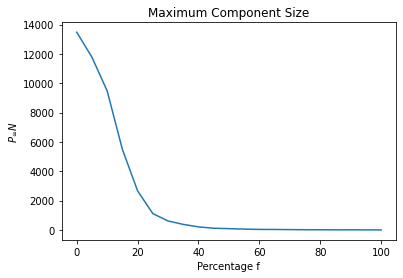

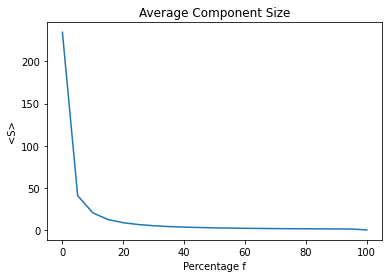

In [60]:
plt.figure()
plt.plot(fractions*100, Gc_max)
plt.ylabel("$P_{\infty}N$")
plt.xlabel("Percentage f")
plt.title("Maximum Component Size")

plt.figure()
plt.plot(fractions*100, Gc_avg)
plt.ylabel("<S>")
plt.xlabel("Percentage f")
plt.title("Average Component Size")

Both maximum and average component size are rapidly decreasing, even before a fraction fc or fc_ER is removed, indicating that the network is very prone to random attacks.
(Note: When calculating the average component size we have also included the largest (giant) component)